# Exact simulation with Qiskit SDK primitives



<details>
  <summary><b>Package versions</b></summary>

  The code on this page was developed using the following requirements.
  We recommend using these versions or newer.

  ```
  qiskit[all]~=2.1.1
  ```
</details>



The reference primitives in the Qiskit SDK perform local statevector simulations. These simulations do not support
modeling device noise, but are useful for quickly prototyping algorithms before looking into more advanced simulation
techniques ([using Qiskit Aer](./simulate-stabilizer-circuits)) or running on real devices ([Qiskit Runtime primitives](primitives)).

The Estimator primitive can compute expectation values of circuits, and the Sampler primitive can sample
from output distributions of circuits.

The following sections show how to use the reference primitives to run your workflow locally.

## Use the reference Estimator

The reference implementation of `EstimatorV2` in `qiskit.primitives` that runs on a local statevector
simulators is the [`StatevectorEstimator`](../api/qiskit/qiskit.primitives.StatevectorEstimator) class. It can take circuits, observables, and parameters as inputs and returns the locally computed expectation values.

The following code prepares the inputs that will be used in the examples that follow. The expected input type for the
observables is [`qiskit.quantum_info.SparsePauliOp`](../api/qiskit/qiskit.quantum_info.SparsePauliOp). Note that
the circuit in the example is parametrized, but you can also run the Estimator on non-parametrized circuits.

<Admonition type="note">
  Any circuit passed to an Estimator must **not** include any **measurements**.
</Admonition>



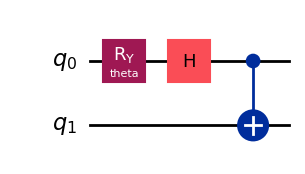

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# circuit for which you want to obtain the expected value
circuit = QuantumCircuit(2)
circuit.ry(Parameter("theta"), 0)
circuit.h(0)
circuit.cx(0, 1)
circuit.draw("mpl", style="iqp")

In [2]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# observable(s) whose expected values you want to compute

observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

# value(s) for the circuit parameter(s)
parameter_values = [[0], [np.pi / 6], [np.pi / 2]]

<Admonition type="tip" title="Transpile to ISA circuits and observables">
  The Qiskit Runtime primitives workflow requires circuits and observables to be transformed to only use instructions supported by the QPU (referred to as *instruction set architecture (ISA)* circuits and observables). The reference primitives still accept abstract instructions, as they rely on local statevector simulations, but transpiling the circuit might still be beneficial in terms of circuit optimization.

  ```python
  # Generate a pass manager without providing a backend
  from qiskit.transpiler import generate_preset_pass_manager

  pm = generate_preset_pass_manager(optimization_level=1)
  isa_circuit = pm.run(circuit)
  isa_observable = observable.apply_layout(isa_circuit.layout)
  ```
</Admonition>

### Initialize Estimator

Instantiate a [`qiskit.primitives.StatevectorEstimator`](../api/qiskit/qiskit.primitives.StatevectorEstimator).



In [3]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

### Run and get results

This example only uses one circuit (of type [`QuantumCircuit`](../api/qiskit/qiskit.circuit.QuantumCircuit)) and one
observable.

Run the estimation by calling the [`StatevectorEstimator.run`](../api/qiskit/qiskit.primitives.StatevectorEstimator#run) method, which returns an instance of a [`PrimitiveJob`](/docs/api/qiskit/qiskit.primitives.PrimitiveJob) object. You can get the results from the job (as a [`qiskit.primitives.PrimitiveResult`](../api/qiskit/qiskit.primitives.PrimitiveResult) object)
with the [`qiskit.primitives.PrimitiveJob.result`](../api/qiskit/qiskit.primitives.PrimitiveJob#result) method.



In [4]:
job = estimator.run([(circuit, observable, parameter_values)])
result = job.result()
print(f" > Result class: {type(result)}")

 > Result class: <class 'qiskit.primitives.containers.primitive_result.PrimitiveResult'>


#### Get the expected value from the result

The primitives result outputs an array of [`PubResult`s](/docs/api/qiskit/qiskit.primitives.PubResult#pubresult), where each item of the array is a `PubResult` object that contains in its data the array of evaluations corresponding to every circuit-observable combination in the PUB.

To retrieve the expectation values and metadata for the first (and in this case, only) circuit evaluation, we must access the evaluation [`data`](/docs/api/qiskit/qiskit.primitives.PubResult#data) for PUB 0:



In [5]:
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")

 > Expectation value: [4.         3.73205081 2.        ]
 > Metadata: {'target_precision': 0.0, 'circuit_metadata': {}}


### Set Estimator run options

By default, the reference Estimator performs an exact statevector calculation based on the
[`quantum_info.Statevector`](../api/qiskit/qiskit.quantum_info.Statevector) class.
However, this can be modified to introduce the effect of the sampling overhead (also known as "shot noise").

Estimator accepts a `precision` argument that expresses the error bars that the
primitive implementation should target for expectation values estimates.  This is the sampling overhead and is defined exclusively in the `.run()` method. This  lets you fine-tune the option all the way to the PUB level.



In [6]:
# Estimate expectation values for two PUBs, both with 0.05 precision.
precise_job = estimator.run(
    [(circuit, observable, parameter_values)], precision=0.05
)

For a full example, see the [Primitives examples](primitives-examples#estimator-examples) page.

## Use the reference Sampler

The reference implementations of `SamplerV2` in `qiskit.primitives` is the [`StatevectorSampler`](../api/qiskit/qiskit.primitives.StatevectorSampler) class. It takes circuits and parameters as inputs and returns the results from sampling from the output probability distributions as a quasi-probability distribution of output states.

The following code prepares the inputs used in the examples that follow. Note that
these examples run a single parametrized circuit, but you can also run the Sampler
on non-parametrized circuits.



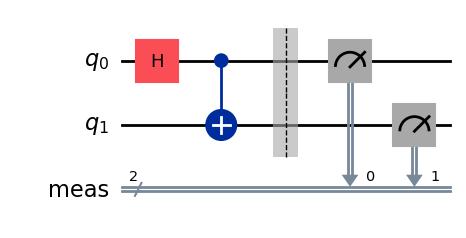

In [7]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
circuit.draw("mpl", style="iqp")

<Admonition type="note">
  Any quantum circuit passed to a Sampler **must** include measurements.
</Admonition>

<Admonition type="tip" title="Transpile to ISA circuits and observables">
  The Qiskit Runtime primitives workflow requires circuits to be transformed to only use instructions supported by the QPU (referred to as ISA circuits). The reference primitives still accept abstract instructions, as they rely on local statevector simulations, but transpiling the circuit might still be beneficial in terms of circuit optimization.

  ```python
  # Generate a pass manager without providing a backend
  from qiskit.transpiler import generate_preset_pass_manager

  pm = generate_preset_pass_manager(optimization_level=1)
  isa_circuit = pm.run(qc)
  ```
</Admonition>

### Initialize `SamplerV2`

Instantiate [`qiskit.primitives.StatevectorSampler`](../api/qiskit/qiskit.primitives.StatevectorSampler):



In [8]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

### Run and get results



In [9]:
# execute 1 circuit with Sampler
job = sampler.run([circuit])
pub_result = job.result()[0]
print(f" > Result class: {type(pub_result)}")

 > Result class: <class 'qiskit.primitives.containers.sampler_pub_result.SamplerPubResult'>


Primitives accept multiple PUBs as inputs, and each PUB gets its own result. Therefore, you can run different circuits with various parameter/observable combinations, and retrieve the PUB results:



In [10]:
from qiskit.transpiler import generate_preset_pass_manager

# create two circuits
circuit1 = circuit.copy()
circuit2 = circuit.copy()

# transpile circuits
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit1 = pm.run(circuit1)
isa_circuit2 = pm.run(circuit2)
# execute 2 circuits using Sampler
job = sampler.run([(isa_circuit1), (isa_circuit2)])
pub_result_1 = job.result()[0]
pub_result_2 = job.result()[1]
print(f" > Result class: {type(pub_result)}")

 > Result class: <class 'qiskit.primitives.containers.sampler_pub_result.SamplerPubResult'>


### Get the probability distribution or measurement outcome

Measurement outcome samples are returned as **bitstrings** or **counts**. The bitstrings show the measurement outcomes, preserving the shot order in which they were measured. The Sampler result objects organize data in terms of their input circuits' classical register names, for compatibility with dynamic circuits.

<Admonition>
  The name of the classical register defaults to `"meas"`. This name will be used later to access the measurement bitstrings.
</Admonition>



In [11]:
# Define quantum circuit with 2 qubits
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
circuit.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

In [12]:
# Transpile circuit
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit = pm.run(circuit)
# Run using sampler
result = sampler.run([circuit]).result()
# Access result data for PUB 0
data_pub = result[0].data
# Access bitstring for the classical register "meas"
bitstrings = data_pub.meas.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")
# Get counts for the classical register "meas"
counts = data_pub.meas.get_counts()
print(f"The counts are: {counts}")

The number of bitstrings is: 1024
The counts are: {'00': 534, '11': 490}


### Change run options

By default, the reference Sampler performs an exact statevector calculation based on the
[`quantum_info.Statevector`](../api/qiskit/qiskit.quantum_info.Statevector) class.
However, this can be modified to introduce the effect of the sampling overhead (also known as "shot noise"). To help manage this overhead, the Sampler interface accepts a `shots` argument that can be defined at the PUB level.

This example assumes you have defined two circuits.



In [13]:
# Sample two circuits at 128 shots each.
sampler.run([isa_circuit1, isa_circuit2], shots=128)
# Sample two circuits at different amounts of shots. The "None"s are necessary
# as placeholders
# for the lack of parameter values in this example.
sampler.run([(isa_circuit1, None, 123), (isa_circuit2, None, 456)])

For a full example, see the [Primitives examples](./primitives-examples#sampler-examples) page.

## Next steps

<Admonition type="tip" title="Recommendations">
  *   For higher-performance simulation that can handle larger circuits, or to incorporate noise models into your simulation, see [Exact and noisy simulation with Qiskit Aer primitives](simulate-with-qiskit-aer).
  *   To learn how to use Quantum Composer for simulation, see the [IBM Quantum Composer](/docs/guides/composer) guide.
  *   Read the [Qiskit Estimator API](/docs/api/qiskit/1.4/qiskit.primitives.Estimator) reference.
  *   Read the [Qiskit Sampler API](/docs/api/qiskit/1.4/qiskit.primitives.Sampler) reference.
  *   Learn how to run on a QPU in the [Run](./execute-on-hardware) step of the Qiskit patterns workflow.
  *   Read [Migrate to V2 primitives](/docs/migration-guides/v2-primitives).
</Admonition>



© IBM Corp., 2017-2025